In [1]:
import os
import cv2
import numpy as np


parent_dir = '/Users/saikarthik/Desktop/scp/dataset'


categories = os.listdir(parent_dir)


category_images = {}
category_labels = {}


for category in categories:
    category_dir = os.path.join(parent_dir, category)
    

    if os.path.isdir(category_dir) and category != '.DS_Store':
        all_files = os.listdir(category_dir)
        image_files = [filename for filename in all_files if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images = []  # An empty list to store the processed images for the current category
        labels = [category] * len(image_files)
        

        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting to RGB format
            resized_image = cv2.resize(image_rgb, (224, 224))  # Resizing the image to a 224x224 pixel size
            images.append(resized_image)
    
        category_images[category] = np.array(images)
        category_labels[category] = np.array(labels)

        print(f"Shape of images for category '{category}': {category_images[category].shape}")


Shape of images for category 'VeryMildDemented': (2308, 224, 224, 3)
Shape of images for category 'ModerateDemented': (132, 224, 224, 3)
Shape of images for category 'MildDemented': (964, 224, 224, 3)
Shape of images for category 'NonDemented': (3268, 224, 224, 3)


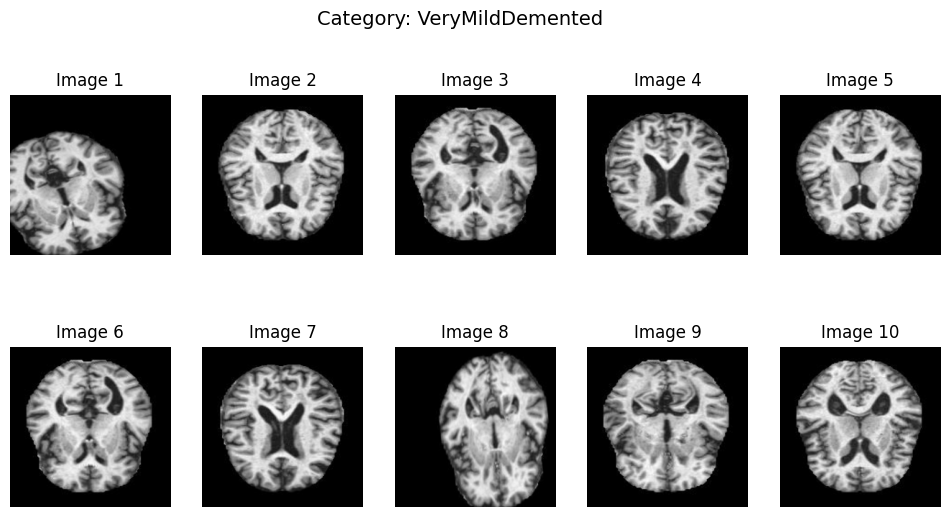

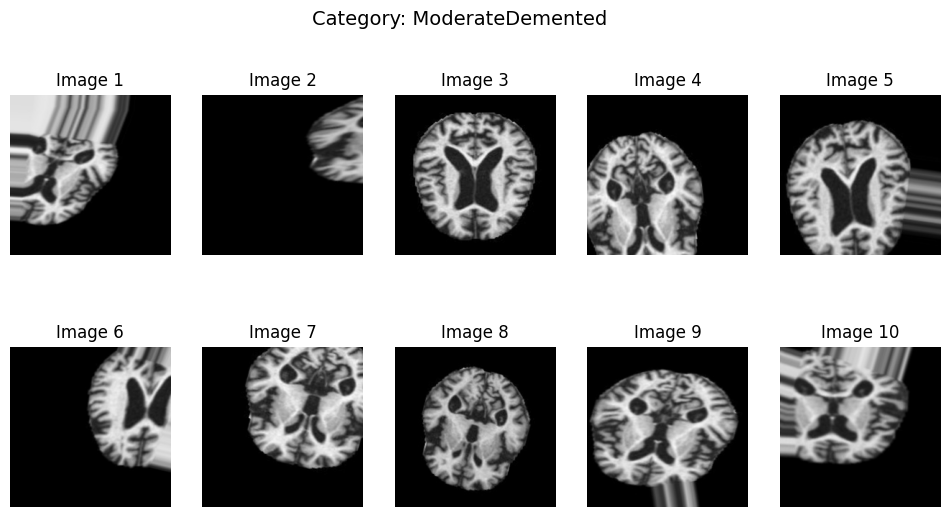

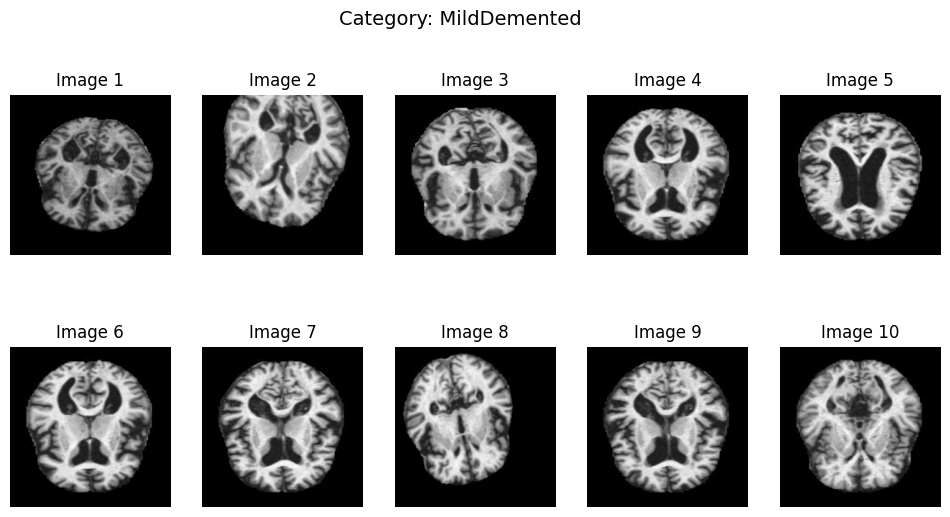

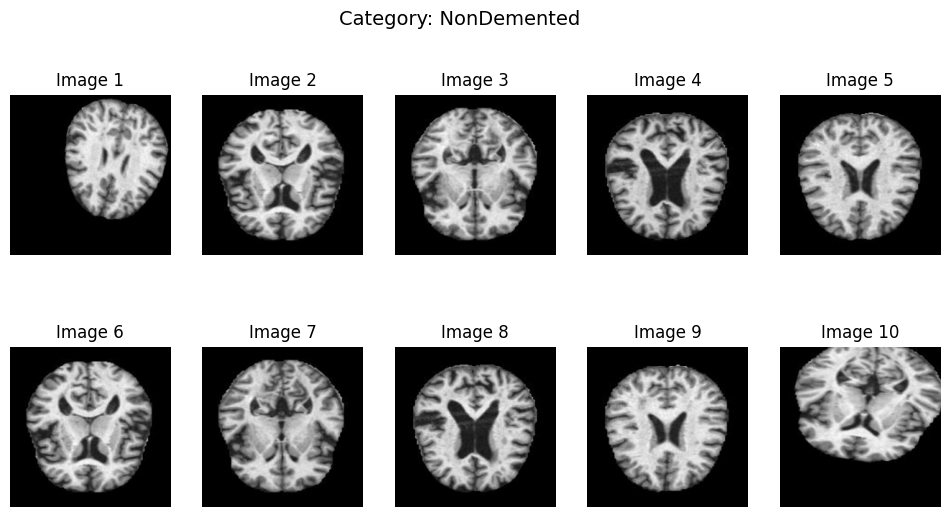

In [2]:
import matplotlib.pyplot as plt


for category in categories:
    if category not in category_images:
        continue
    
    sample_images = category_images[category][:10]  # Taking the first 10 images as a sample

    plt.figure(figsize=(12, 6))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.suptitle(f"Category: {category}", fontsize=14)
    plt.show()


In [3]:

for category in category_images:
    category_images[category] = category_images[category] / 255.0


min_value = np.min(category_images[category])
max_value = np.max(category_images[category])


print(f"Minimum Pixel Value: {min_value}")
print(f"Maximum Pixel Value: {max_value}")


Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotating the image by up to 20 degrees
    width_shift_range=0.2,  # Shifting the width by up to 20% of the image width
    height_shift_range=0.2,  # Shifting the height by up to 20% of the image height
    shear_range=0.2, 
    zoom_range=0.2,  # Zoom in by up to 20%
    horizontal_flip=True,  # Fliping the image horizontally
    fill_mode='nearest'  # Fill in new pixels with the nearest existing pixel
)

output_dir = '/Users/saikarthik/Desktop/scp/dataset'  # Changing to our desired output directory

# Creating the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Looping through each category and apply data augmentation
for category in categories:
    if category not in category_images:
        continue

    images = category_images[category]
    category_output_dir = os.path.join(output_dir, category)
    if not os.path.exists(category_output_dir):
        os.makedirs(category_output_dir)
    i = 0
    for batch in datagen.flow(images, batch_size=1):
        augmented_image = batch[0]
        augmented_image = (augmented_image * 255).astype(np.uint8)  
        filename = f'{i}.jpg' 
        save_path = os.path.join(category_output_dir, filename)
        cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
        i += 1
        if i >= 100:  
            break


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# removing the top classification layers
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)


parent_dir = '/Users/saikarthik/Desktop/scp/dataset'

# List of  all subdirectories 
categories = os.listdir(parent_dir)


category_features = {}
category_labels = {}

# Looping through each subdirectory
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    

    if os.path.isdir(category_dir) and category != '.DS_Store':
        all_files = os.listdir(category_dir)
        
        image_files = [filename for filename in all_files if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Initializing lists to store features and labels for the category
        features = []  
        labels = [category] * len(image_files)
        
    
        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            resized_image = cv2.resize(image_rgb, (224, 224))  
            preprocessed_image = preprocess_input(np.expand_dims(resized_image, axis=0))  
            features.append(feature_extractor.predict(preprocessed_image)[0])  
        

        category_features[category] = np.array(features)
        category_labels[category] = np.array(labels)




2024-11-15 19:06:13.686286: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-15 19:06:13.686330: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-15 19:06:13.686346: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-15 19:06:13.686738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-15 19:06:13.687063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/1 [==============================] - 0s 12ms/step


2024-11-15 19:06:14.290375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


In [6]:
# Combine all features and labels into a single dataset
all_features = np.concatenate(list(category_features.values()))
all_labels = np.concatenate(list(category_labels.values()))

In [7]:
all_features

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           3.6662188 ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , 39.427086  , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [8]:
all_labels

array(['VeryMildDemented', 'VeryMildDemented', 'VeryMildDemented', ...,
       'NonDemented', 'NonDemented', 'NonDemented'], dtype='<U16')

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np
num_samples = all_features.shape[0]
all_features_reshaped = all_features.reshape(num_samples, -1)

# Standardize the reshaped features
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features_reshaped)




In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(all_labels_encoded.reshape(-1, 1))


In [11]:
all_features

array([[-0.02366601, -0.02984692, -0.03679322, ..., -0.03021036,
         0.12961806, -0.05106451],
       [-0.02366601, -0.02984692, -0.03679322, ..., -0.03021036,
        -0.12863688, -0.05106451],
       [-0.02366601, -0.02984692, -0.03679322, ..., -0.03021036,
        -0.72598183, -0.05106451],
       ...,
       [-0.02366601, -0.02984692, -0.03679322, ..., -0.03021036,
        -0.44760674, -0.05106451],
       [-0.02366601, -0.02984692, -0.03679322, ..., -0.03021036,
        -0.72598183, -0.05106451],
       [-0.02366601, -0.02984692, -0.03679322, ..., -0.03021036,
        -0.11591294, -0.05106451]], dtype=float32)

In [12]:
all_labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [13]:
np.save('all_features_vgg16.npy', all_features)

np.save('all_labels_vgg16.npy', all_labels)